In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# Load and inspect data

In [2]:
df = pd.read_csv("data/data-salary-3.txt")
print(len(df))
df.head(5)

300


,X,Y,KID,GID
0,7,457,1,1
1,10,482,1,1
2,16,518,1,1
3,25,535,1,1
4,5,427,1,1


In [3]:
df["X"].min(), df["X"].max()

(0, 34)

In [4]:
df["Y"].min(), df["Y"].max()

(161, 1521)

In [5]:
df["KID"].min(), df["KID"].max()

(1, 30)

In [6]:
def scatter_plot(ax, df):
    sns.scatterplot(
        ax=ax, 
        data=df, x="X", y="Y", 
        style="GID", hue="GID", 
        markers=['o', '^', 'X'],
        s=100,
        edgecolor='k', linewidths=10
    )

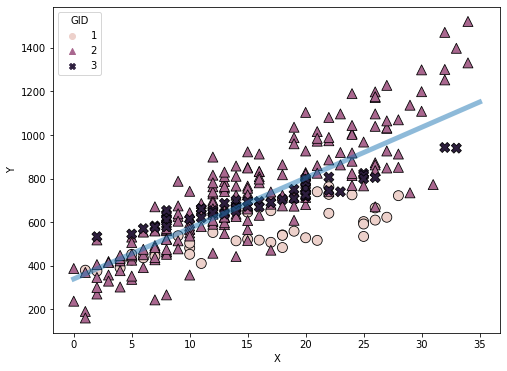

In [7]:
# Fig 8.5 left
lr = LinearRegression()
lr.fit(X=df["X"].values.reshape(-1, 1), y=df["Y"])
xx = np.linspace(0, 35, 11)
yy_all = lr.predict(xx.reshape(-1, 1))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(xx, yy_all, linewidth=5, alpha=0.5)
scatter_plot(ax, df)
fig.show()

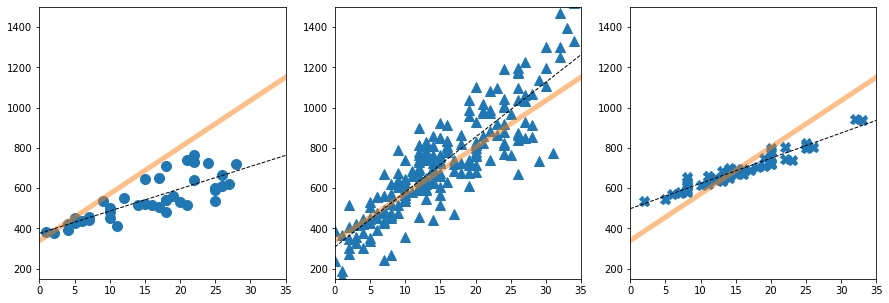

In [8]:
# Fig 8.5 right

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
GIDs = [1, 2, 3]
styles = ['o', '^', 'X']
xx = np.linspace(0, 35, 11)


for ax, GID, style in zip(axes, GIDs, styles):
    df_tmp = df[df["GID"]==GID]
    lr_tmp = LinearRegression()
    lr_tmp.fit(X=df_tmp["X"].values.reshape(-1, 1), y=df_tmp["Y"])
    yy_tmp = lr_tmp.predict(xx.reshape(-1, 1))

    ax.plot(df_tmp["X"], df_tmp["Y"], style, label=str(GID), markersize=10)
    ax.set_xlim(0, 35)
    ax.set_ylim(150, 1500)
    ax.plot(xx, yy_all, linewidth=5, alpha=0.5)  # regression line for the whole data
    ax.plot(xx, yy_tmp, "k--", linewidth=1)  # regression line for the current GID

fig.show()    

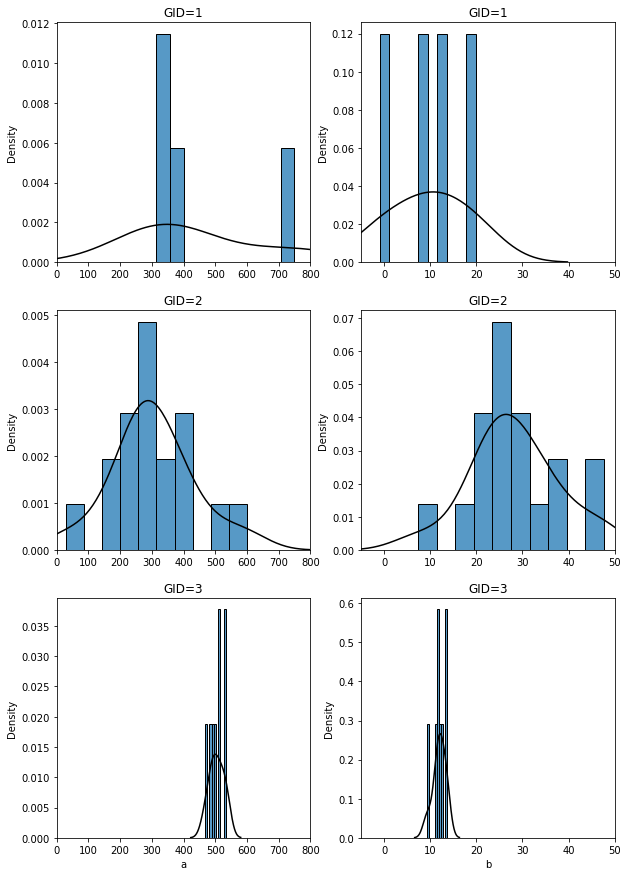

In [9]:
# Fig 8.6 (Density, instead of count)

KIDs = range(1, 31, 1)
a = defaultdict(list)  # intercepts
b = defaultdict(list) # coefficients

for KID in KIDs:
    df_tmp = df[df["KID"]==KID]  # focus on a single company
    GID = df_tmp.iloc[0]["GID"] # obtain the GID of the company by taking the first row 
    lr_tmp = LinearRegression()
    lr_tmp.fit(X=df_tmp["X"].values.reshape(-1, 1), y=df_tmp["Y"])
    a[GID].append(lr_tmp.intercept_)
    b[GID].append(lr_tmp.coef_[0])

    
def hist_density_plot(ax, x):
    sns.histplot(ax=ax, stat="density", x=x, bins=10)
    sns.kdeplot(ax=ax, x=x, color='k')
    

a_min = 0
a_max = 800
b_min = -5
b_max = 50
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
for i in range(3):
    ax = axes[i][0]
    hist_density_plot(ax, a[i+1])
    ax.set_title(f"GID={i+1}")
    ax.set_xlim(a_min, a_max)
    
    ax = axes[i][1]
    hist_density_plot(ax, b[i+1])
    ax.set_title(f"GID={i+1}")
    ax.set_xlim(b_min, b_max)

    
axes[2][0].set_xlabel("a")
axes[2][1].set_xlabel("b")
fig.show()

# Model 8-5

In [10]:
model8_5 = CmdStanModel(stan_file="model/model8-5.stan")
print(model8_5)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chapter08/model/model8-5


CmdStanModel: name=model8-5
	 stan_file=/workdir/chapter08/model/model8-5.stan
	 exe_file=/workdir/chapter08/model/model8-5
	 compiler_optons=stanc_options=None, cpp_options=None


In [11]:
K2G = [0] * df.nunique()["KID"]
tmp = df.groupby(by="KID").first()["GID"]
for KID, GID in zip(tmp.index, tmp.values):
    K2G[KID-1] = int(GID)  # if it is not cast to int, "x is not json serializable" error occurs

data8_5 = {
    "N": len(df),
    "G": int(df.nunique()["GID"]),
    "K": int(df.nunique()["KID"]),
    "X": df["X"].values,
    "Y": df["Y"].values,
    "KID": df["KID"].values,
    "K2G": K2G
}

fit8_5 = model8_5.sample(data=data8_5)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [12]:
summary8_5 = fit8_5.summary()
summary8_5

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1585.0400,0.851012,13.6105,-1604.2900,-1586.5700,-1559.3300,255.784,26.4924,1.01192
a0,401.8950,22.762400,590.9250,-148.5960,386.0990,1017.1100,673.951,69.8033,1.00406
b0,20.7338,3.766210,98.9389,-24.2264,18.1505,56.0976,690.119,71.4779,1.00890
a1[1],359.0000,0.810000,30.0000,310.0000,358.0000,408.0000,1386.000,144.0000,1.00000
a1[2],300.0000,0.410000,15.0000,276.0000,301.0000,324.0000,1310.000,136.0000,1.00000
...,...,...,...,...,...,...,...,...,...
s_ag,601.4000,57.500000,1532.5000,67.2000,216.9000,2231.9000,711.400,73.7000,1.00000
s_bg,76.5000,26.000000,903.1000,6.4000,17.8000,155.5000,1210.700,125.4000,1.00000
s_a,27.7000,0.600000,12.0000,9.1000,26.9000,48.5000,386.400,40.0000,1.00000


In [13]:
# convergence check
summary8_5[summary8_5["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


In [14]:
# convergence check
print(fit8_5.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmpkmujj70r/model8-5-202010271219-1-q_gjszb0.csv, /tmp/tmpkmujj70r/model8-5-202010271219-2-c41ubin6.csv, /tmp/tmpkmujj70r/model8-5-202010271219-3-0gghxhxw.csv, /tmp/tmpkmujj70r/model8-5-202010271219-4-wxxn4xyc.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
63 of 4000 (1.6%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


Processing csv files: /tmp/tmpkmujj70r/model8-5-202010271219-1-q_gjszb0.csv, /tmp/tmpkmujj70r/model8-5-202010271219-2-c41ubin6.csv, /tmp/tmpkmujj70r/model8-5-202010271219-3-0gghxhxw.csv, /tmp/tmpkmujj70r/model8-5-202010271219-4-wxxn4xyc.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
63 of 4000 (1.6%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


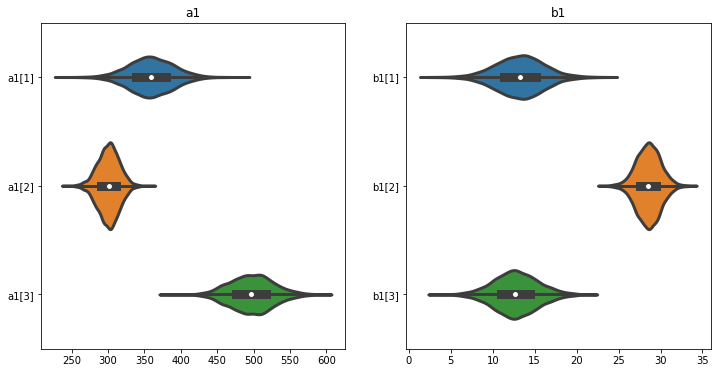

In [15]:
# exercise (3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.violinplot(ax=axes[0], data=fit8_5.stan_variable("a1"), orient="h", linewidth=3)
axes[0].set_yticklabels(["a1[1]", "a1[2]", "a1[3]"])
axes[0].set_title("a1")
sns.violinplot(ax=axes[1], data=fit8_5.stan_variable("b1"), orient="h", linewidth=3)
axes[1].set_yticklabels(["b1[1]", "b1[2]", "b1[3]"])
axes[1].set_title("b1")

fig.show()

# Model 8-6

In [16]:
model8_6 = CmdStanModel(stan_file="model/model8-6.stan")
print(model8_6)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chapter08/model/model8-6


CmdStanModel: name=model8-6
	 stan_file=/workdir/chapter08/model/model8-6.stan
	 exe_file=/workdir/chapter08/model/model8-6
	 compiler_optons=stanc_options=None, cpp_options=None


In [24]:
K2G = [0] * df.nunique()["KID"]
tmp = df.groupby(by="KID").first()["GID"]
for KID, GID in zip(tmp.index, tmp.values):
    K2G[KID-1] = int(GID)  # if it is not cast to int, "x is not json serializable" error occurs

data8_6 = {
    "N": len(df),
    "G": int(df.nunique()["GID"]),
    "K": int(df.nunique()["KID"]),
    "X": df["X"].values,
    "Y": df["Y"].values,
    "KID": df["KID"].values,
    "K2G": K2G,
    "GID": df["GID"].values
}

fit8_6 = model8_6.sample(data=data8_6)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


In [25]:
summary8_6 = fit8_6.summary()
summary8_6

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1474.6500,0.830456,12.1724,-1492.8800,-1475.620,-1452.9600,214.843,13.7017,1.02568
a0,405.7990,53.185800,671.2810,-220.0430,392.359,906.0060,159.301,10.1595,1.01576
b0,13.8712,5.071470,87.1640,-36.0797,17.961,68.8359,295.397,18.8391,1.00611
a1[1],382.0000,2.100000,85.0000,271.0000,371.000,527.0000,1727.000,110.0000,1.00000
a1[2],301.0000,0.510000,17.0000,273.0000,300.000,330.0000,1153.000,74.0000,1.00000
...,...,...,...,...,...,...,...,...,...
s_b[2],5.7000,0.028000,1.3000,4.0000,5.600,8.1000,1952.000,124.0000,1.00000
s_b[3],1.0000,0.019000,0.5800,0.2500,0.930,2.0000,898.000,57.0000,1.00000
s_Y[1],29.0000,0.074000,3.8000,23.0000,28.000,35.0000,2636.000,168.0000,1.00000


In [26]:
fit8_6.stan_variable("a1").min(), fit8_6.stan_variable("a1").max()

(-495.642, 849.285)

In [27]:
# convergence check
summary8_6[summary8_6["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


In [28]:
# convergence check
print(fit8_6.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmpkmujj70r/model8-6-202010271222-1-6z4oei8u.csv, /tmp/tmpkmujj70r/model8-6-202010271222-2-aei1algk.csv, /tmp/tmpkmujj70r/model8-6-202010271222-3-sxal349q.csv, /tmp/tmpkmujj70r/model8-6-202010271222-4-f1_v_8pq.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
132 of 4000 (3.3%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


Processing csv files: /tmp/tmpkmujj70r/model8-6-202010271222-1-6z4oei8u.csv, /tmp/tmpkmujj70r/model8-6-202010271222-2-aei1algk.csv, /tmp/tmpkmujj70r/model8-6-202010271222-3-sxal349q.csv, /tmp/tmpkmujj70r/model8-6-202010271222-4-f1_v_8pq.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
132 of 4000 (3.3%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


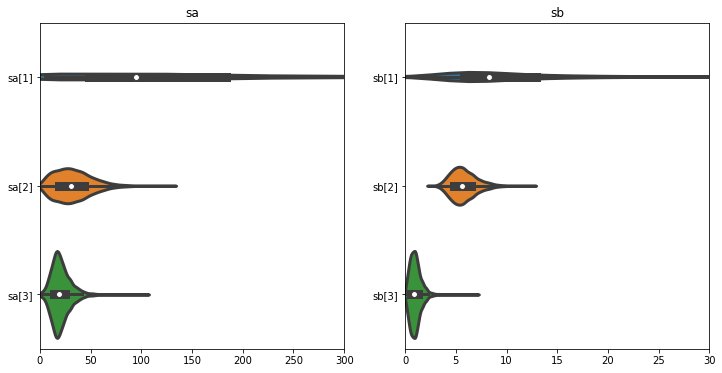

In [29]:
# NOTE : considerable numbers of outliers exist for GID=1, because of which xlim is explicitly set.
# The behavior is natural, because there are only 4 companies for GID=1.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.violinplot(ax=axes[0], data=fit8_6.stan_variable("s_a"), orient="h", linewidth=3)
axes[0].set_yticklabels(["sa[1]", "sa[2]", "sa[3]"])
axes[0].set_title("sa")
axes[0].set_xlim(0, 300)
sns.violinplot(ax=axes[1], data=fit8_6.stan_variable("s_b"), orient="h", linewidth=3)
axes[1].set_yticklabels(["sb[1]", "sb[2]", "sb[3]"])
axes[1].set_title("sb")
axes[1].set_xlim(0, 30)

fig.show()

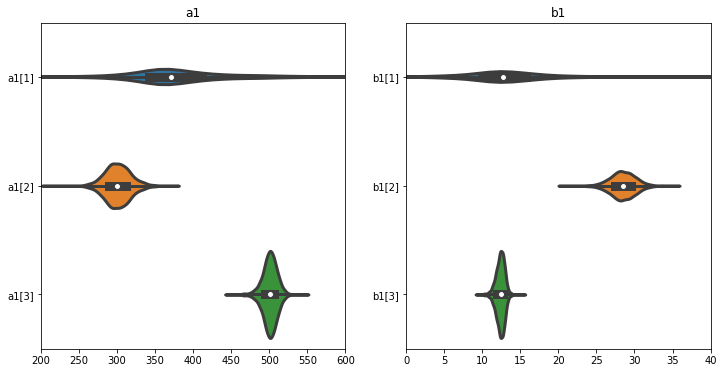

In [30]:
# NOTE : considerable numbers of outliers exist, because of which xlim is explicitly set.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.violinplot(ax=axes[0], data=fit8_6.stan_variable("a1"), orient="h", linewidth=3)
axes[0].set_yticklabels(["a1[1]", "a1[2]", "a1[3]"])
axes[0].set_title("a1")
axes[0].set_xlim(200, 600)
sns.violinplot(ax=axes[1], data=fit8_6.stan_variable("b1"), orient="h", linewidth=3)
axes[1].set_yticklabels(["b1[1]", "b1[2]", "b1[3]"])
axes[1].set_title("b1")
axes[1].set_xlim(0, 40)

fig.show()